# Units etc

$P_s$ surface pressure (mBar)

$P_w$ partial pressure of water (mBar)

$T_s$ surface temp (K)

$N_0$ is (refractive index -1) times 10**6

# Brussard and Watson (1995)

$$ N_0 = 77.6 \frac{P_s}{T_s} -5.6  \frac{P_w}{T_s} +3.75\times 10^5 \frac{P_w}{{T_s}^2}$$ 


# Smith and Weintrab (1953) 

$$ N_0 = 77.6 \frac{P_s}{T_s} -12.8 \frac{P_w}{T_s} +3.776\times 10^5 \frac{P_w}{{T_s}^2}$$

In [1]:
# P_w
import numpy as np

def pw(T,RH):
    """
    Given T in Kelvin and Relativ Humidity (%)
    calculate water vapoir pressure
    From Crane (1976) Methods of Experimental physics (12 part B)
    """
    e_sat= 6.105*np.exp(25.22*(T-273.)/T  - 5.31*np.log(T/273.)) # saturation pressure
    Pw=RH*e_sat/100.
    return Pw

def pw_buck(Ps,T,RH):
    """
    Buck 1981
    """
    e_sat=(1.0007 - 3.46e-6*Ps)*6.1121*np.exp((17.502*(T-273.15))/(T-32.18))
    Pw=RH*e_sat/100.
    return Pw
    

#  30% humidity at 300K (27C)

In [2]:
print pw(300,30.), pw_buck(900.,300,30.), "millibars"

10.74183139232577 10.575335824383483 millibars


In [3]:
def bw(Ps,Pw,T):
    """
    N0 from Brussard and Watson
    """
    N= 77.6*Ps/T -5.6*Pw/T +3.75e5*Pw/T**2
    return N

def sw(Ps,Pw,T):
    """
    N0 from Smith and Weintraub
    """
    N= 77.6*Ps/T -12.8*Pw/T +3.776e5*Pw/T**2
    return N


In [4]:
print bw(900,10.6,300), sw(900,10.6,300)

276.7688 276.820622222


# Ulich model

Based on *Brussard and Watson*

$$ R  = 16.01\frac{P_s}{T_s} -1.15 \frac{P_w}{T_s} + 7.734937\times10^4 \frac{P_w}{{T_s}^2}$$

R is in arcseconds

In [5]:
def refac_u(Ps,Pw,T):
    """
    Refraction constant in arsec
    from Ulich (1981)
    based on Brussard and Watson
    el in degrees 
    """
    r0= 16.01*Ps/T - 1.15*Pw/T +7.734937e4*Pw/T**2
    return r0


def el_factor(el):
    """
    Elevation dependance used by Ulich
    """
    E=np.radians(el)
    E_off=np.radians(87.5)
    f=np.cos(E)/(np.sin(E)+0.00175*np.tan(E_off-E))
    return f


In [6]:
print refac_u(900,10,300)

56.5860411111


In [7]:
factor=el_factor(20.)
const=refac_u(900,10,300)
offset=factor*const
print offset, "Arcsec"

153.57184263076988 Arcsec


In [8]:
# model used by katpoint

def refraction_offset_vlbi(el, temperature_C, pressure_hPa, humidity_percent):
    """Calculate refraction correction using model in VLBI Field System.
    This uses the refraction model in the VLBI Field System to calculate a
    correction to a given elevation angle to account for refractive bending in
    the atmosphere, based on surface weather measurements. Each input parameter
    can either be a scalar value or an array of values, as long as all arrays
    are of the same shape.
    Parameters
    ----------
    el : float or array
        Requested elevation angle(s), in radians
    temperature_C : float or array
        Ambient air temperature at surface, in degrees Celsius
    pressure_hPa : float or array
        Total barometric pressure at surface, in hectopascal (hPa) or millibars
    humidity_percent : float or array
        Relative humidity at surface, as a percentage in range [0, 100]
    Returns
    -------
    el_offset : float or array
        Refraction offset(s) in radians, which needs to be *added* to
        elevation angle(s) to correct it
    Notes
    -----
    The code is based on poclb/refrwn.c in Field System version 9.9.2, which
    was added on 2006-11-15. This is a C version (with typos fixed) of the
    Fortran version in polb/refr.f. As noted in the Field System
    documentation [1]_, the refraction model originated with the Haystack
    pointing system, but the documentation for this algorithm seems to have
    been lost. It agrees well with the DSN refraction model, though.
    References
    ----------
    .. [1] Himwich, "Station Programs," Mark IV Field System Reference Manual,
       Version 8.2, 1 September 1993, available at
       `<ftp://gemini.gsfc.nasa.gov/pub/fsdocs/stprog.pdf>`_
    """
    p = (0.458675e1, 0.322009e0, 0.103452e-1, 0.274777e-3, 0.157115e-5)
    cvt = 1.33289
    a = 40.
    b = 2.7
    c = 4.
    d = 42.5
    e = 0.4
    f = 2.64
    g = 0.57295787e-4

    deg2rad=0.017453292519943295
    rad2deg=57.295779513082323
    
    
    # Compute SN (surface refractivity) (via dewpoint and water vapor partial pressure? [LS])
    rhumi = (100. - humidity_percent) * 0.9
    dewpt = temperature_C - rhumi * (0.136667 + rhumi * 1.33333e-3 + temperature_C * 1.5e-3)
    pp = p[0] + p[1] * dewpt + p[2] * dewpt ** 2 + p[3] * dewpt ** 3 + p[4] * dewpt ** 4
    temperature_K = temperature_C + 273.
    # This looks like Smith & Weintraub (1953) or Crane (1976) [LS]
    sn = 77.6 * (pressure_hPa + (4810.0 * cvt * pp) / temperature_K) / temperature_K

# removed clipping section as irrelevant, we can't go below 15deg
    
    el_deg = rad2deg*el
    aphi = a / ((el_deg + b) ** c)
    dele = -d / ((el_deg + e) ** f)
    zenith_angle = deg2rad*(90. - el_deg)
    bphi = g * (np.tan(zenith_angle) + dele)
    # Threw out an (el < 0.01) check here, which will never succeed because el is clipped to be above 1.0 [LS]
    return 3600*(bphi * sn - aphi) # arcseconds  for me



In [9]:
print refraction_offset_vlbi(np.radians(20), 27., 900., 30.), "arcsec"

160.19841999528742 arcsec


In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


10.668967418711311


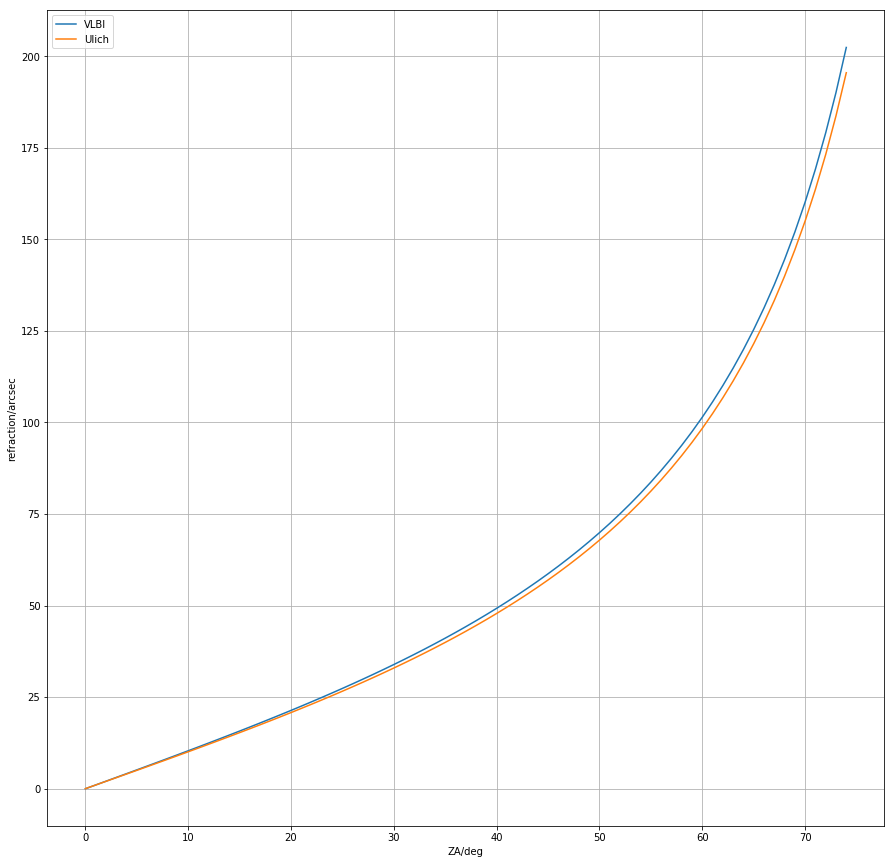

In [11]:
za=np.arange(0.,75.,1.) # degrees
#print za
el=90-za
elr=np.radians(el)
T=27. # Celsius
kelvin=T+273.15
press=900. #mbar
rh=30. # relative humidity %
# Now calculate and plot

hum=pw_buck(press,kelvin,rh) # absolute humidity
ul_ref=refac_u(press,hum,kelvin)*el_factor(el)
print hum
pylab.figure(figsize=(15.,15.))
pylab.plot(za,refraction_offset_vlbi(elr,T,press,rh),label="VLBI")
pylab.plot(za, ul_ref,label="Ulich")
pylab.xlabel("ZA/deg")
pylab.ylabel("refraction/arcsec")
pylab.legend()
pylab.grid()
pylab.show()